In [1]:
#Importing all the necessary libraries required for our Decision Tree AI
import numpy as np
import pandas as pd
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from six import StringIO 
import csv
from IPython.display import Image
import pydotplus
from termcolor import colored
from sklearn.model_selection import train_test_split
import json
from sklearn.tree import DecisionTreeClassifier
from nbconvert import PythonExporter
from sklearn import metrics
import firebase_admin
from firebase_admin import credentials,storage
from firebase_admin import firestore


In [2]:
#Initializing the firestore client to connect to our website database
if not firebase_admin._apps:
   cred = credentials.Certificate("services/we-don-t-byte---ass-firebase-adminsdk-kdbj6-ec500ebd6d.json")
   firebase_admin.initialize_app(cred, {"storageBucket": "we-don-t-byte---ass.appspot.com"})
   db = firestore.client()

In [3]:
#Before loading dataset we declare our column names to easily identify each file in our data.
col_names = ['Prod_ID', 'Prod_Cat', 'User_ID', 'User_Province', 'Event', 'Clicks', 'Wishlist', 'Recommend']

#loading our Dataset(To be slpit into Training and Validation Data)
#Note: Test data will be fetched straight from the database, get compared to the training and validation we have to avoid testing 
#----- the model using the data it has seen already.

pima = pd.read_csv("../../assets/decision_tree/decision_tree_data/Train_Data.csv", header=None, names=col_names)

#Setting our decision features(attributes to be used in our decision making---Decision Tree)
feature_cols = ['Prod_Cat', 'User_Province', 'Clicks', 'Wishlist']

#Setting our X and y variables for our Model -- Using our "Recommend" Column as our label - Since this is a decision tree(Supervised Learning)
#and our feature Columns as our x "terms"
X = pima[feature_cols]
y = pima.Recommend

#Here we split our dataset into training set (75%) and validation set (25%) - (regarded as test in the following line)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#Note: Validation set will be used to Validate(test) our model and eventually calculate our Model accuracy before and after Pruning
# --- but not to recommend...  

#Here we declare our DecisionTreeClassifier as CLF and eventually train it using our train set and the criterion being "entropy"....
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

#We Create two json objects provinceJson and categoryJson to map our provinces and categories, respectively, to numerical values 
#that the model can be able to train and make neccessary calculations with
provinceJson =  '{ "Limpopo" : 1,"Gauteng" : 2,"Free State" : 3,"Western Cape" : 4,"KwaZulu-Natal" : 5,"North West" : 6,"Northern Cape" : 7,"Eastern Cape" : 8,"Mpumalanga" : 9}'

categoryJson =  '{"Books" : 1, "Shoes" : 2, "Clothing" : 3, "Tech" : 4, "Kitchen" : 5}'

loadProvinceJ = json.loads(provinceJson)
   
loadCategoryJ = json.loads(categoryJson)

#Here we keep track of all trained entries for later purposes...(Avoid testing the exact entries we've trained)
# thus avoiding returning large lists as well......
with open('../../assets/decision_tree/decision_tree_data/Train_Data.csv','r') as file1:
    trainedEntries = [line for line in csv.reader(file1, delimiter=',')]


In [4]:
#Here we are collecting all our products from the database (all documents in firebase)
print('collecting Products... ')
products_ref = db.collection('Products')
Products_docs = products_ref.get()

print('collecting User collection... ')
#Collecting the user's collection from firebase
users_ref = db.collection('Users')
users_docs = users_ref.list_documents()
print('All set!!!')

collecting Products... 
collecting User collection... 
All set!!!


In [5]:
#Declare a list of recommendations (This is one of the final products of this Algorithm)
recommended_products = []
wishlistArr = []

uid = '1RvEwuC2eCdzoKyaATXC9pNsXwH3'
    
province = ''
    
#Get User information--- 
userDoc1 = users_ref.document(uid)
colDocs1 =  userDoc1.collection('info').get()
colDocs2 = userDoc1.collection('Wishlist').list_documents()#Items in wishlist
    
#    Province
#
#Load the json value
for colD_doc in colDocs1:
    province = colD_doc.get('province')
    province = loadProvinceJ[province]

    
#Note that here we're only recommending to users with a defined location, if province is null, then no recommendations
# the continue statement goes to the next user (iteration)... else : we iterate through every product in the database running 
# it through our decision tree algorithm and getting a prediction of that and that's what we'll use for recommendations.. 
if province == '':
    print("No recommendations for this user")
else:      
    for x in colDocs2:
        wishlistArr.append(x.id)

        #For each product in the database :   
    for prod_doc in Products_docs:  
        pid = prod_doc.id  #product Id

        s = pid in wishlistArr   #Returning true if the item is in the wishlist.....
                ###
                # Wishlist
                ####
        if s :            
            wishlist = 0
            
        else:
            wishlist = 0   
                
        noOfClicks = 1    #To avoid null errors and a lot other unnecessary errors we give each product at least one click....
            #
            #   Clicks
            #
        if prod_doc.get('clicks')>= 1:
            noOfClicks = prod_doc.get('clicks')
            
        category = prod_doc.get('category')
        # print("Category: " + str(loadCategoryJ[category]))
        # print("Clicks: " + str(noOfClicks))
        category = loadCategoryJ[category]
        
        listTemp = [pid, category, uid, province, 'view', noOfClicks, wishlist] #Create test entry for this product to be run through the decision tree classifier....

        if listTemp in trainedEntries : #Later purposes is now,lol, if this exact entery has been seen before in training, then don't test it
            continue
        else:
                #creating a dataframe from our entry to be able to run through the classifier...
            test_data = pd.DataFrame([listTemp], columns=['Prod_ID', 'Prod_Cat', 'User_ID', 'User_Province', 'Event', 'Clicks', 'Wishlist']) 

            y_predict = clf.predict(test_data[feature_cols]) #Get our 1(recommend) or 0(Do not recommend)

            if(y_predict == 1):
                str = pid    #Using a pipe delimeter
                recommended_products.append(str) #appending to recommendation list

                str = colored(pid, 'green')
                print(str)
            else:
                str = colored(pid, 'red')
                print(str)
               



01jWTF8NnJRanatcqWWA
03qJv4WzHoKBslyT6bcw
0FrZIkNP98yWbVRuE1Wd
0cCtsXbwGQqu7LoLIFmv
0cHxbCxG7mY7xA7l1Dpn
0s4fAbVOqdJv7eYcZ5Zr
0tOD2R8VprURTzYF4b9m
0zwT3y7XarK0kA2m6459
1GOto1UFk2QuXBdSSyUj
1Q30dEBi2W6i358rT2g4
1WCHDQT6LwpTDo6sX1wv
1YZ02BpCyAzkuMs0uTTU
1iSLejnhJVgmRe0iwHkw
1lZkdgEeh9MLTJfUYnby
20EI9jhYnDyhjYX79yCH
2ZIjNxeaNXgZS3KHhMUP
2ffKEUPN9bWtWmYMfo8C
2gs3DUIYZuaXqgZtU0bs
2sGL2xUGipXFhuTiv6yW
2sZA2SnVdR8wgU5Es6CK
2suTIt6CxtXy6j7dnAaH
32JR4GcAFMlyqvzR3LoP
3HDnaI0Tifr70zhnaPK8
3Kcolr6Llq9geCIQ6RQ7
3T805En1xjLM7v1otfWW
3Y0LgxYEZGlkNbfTuxdl
3cOmZEqJC7qH2IVGxRiw
3cSCaJVIW6nwFfaqOTBx
3dCGNLFbfnOQ0OywT4kx
3gDDKe1ZQgQF8KZnjQhy
3nByTl035FS7GLeGRNrs
3q2W3b0EKePJifmPEgDc
4Dhp4WbkatmbhHjXhSGm
4E8f8vxQkdziiqQaXqp1
4FK6VC5Y1Wq3DAiXCfix
4GMHtmQ3hI0XZqBcd5xh
4MwWuvbsMixmFQ833hPy
4OOmxOSXl4C69zGwa5pN
4Vg5mbuEMiXsSLtjxXil
4cZ4BT60EkXGG51vObIq
4cgzaVfIfvUN75tEyrDU
4ePkkxBbKOCC5jMikeRi
4gMqmSyUFk7D0pvzlXii
5LWMrqRdfAsrYjtQIXgH
5PrTkh48sy41zZhJR0zj
5VX3v1OnZ5xw9pqm9OLa
5ZK5OGI46LFvexOL9kPX
5cuwHLDgCmvmv

In [6]:
#export our final list of recommendation as csv file to our assets folder in our project....
np.savetxt("../../assets/decision_tree/decision_tree_outputs/final_recommendations.csv", recommended_products, delimiter=",", fmt='%s')
np.savetxt("../../assets/decision_tree/decision_tree_outputs/final_recommendations.txt", recommended_products, delimiter=",", fmt='%s')

-----------------------------------------------ACCURACY BEFORE PRUNING---------------------------------

0.65

-------------------------------------------------------------------------------------------------------

|--- Wishlist <= 0.50
|   |--- Clicks <= 28.00
|   |   |--- Clicks <= 4.50
|   |   |   |--- Clicks <= 2.50
|   |   |   |   |--- User_Province <= 8.50
|   |   |   |   |   |--- Prod_Cat <= 1.50
|   |   |   |   |   |   |--- Clicks <= 1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Clicks >  1.50
|   |   |   |   |   |   |   |--- User_Province <= 3.50
|   |   |   |   |   |   |   |   |--- User_Province <= 2.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- User_Province >  2.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- User_Province >  3.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Prod_Cat >  1.50
|   |   |   |   |   |   |--- Prod_Cat <= 2.50


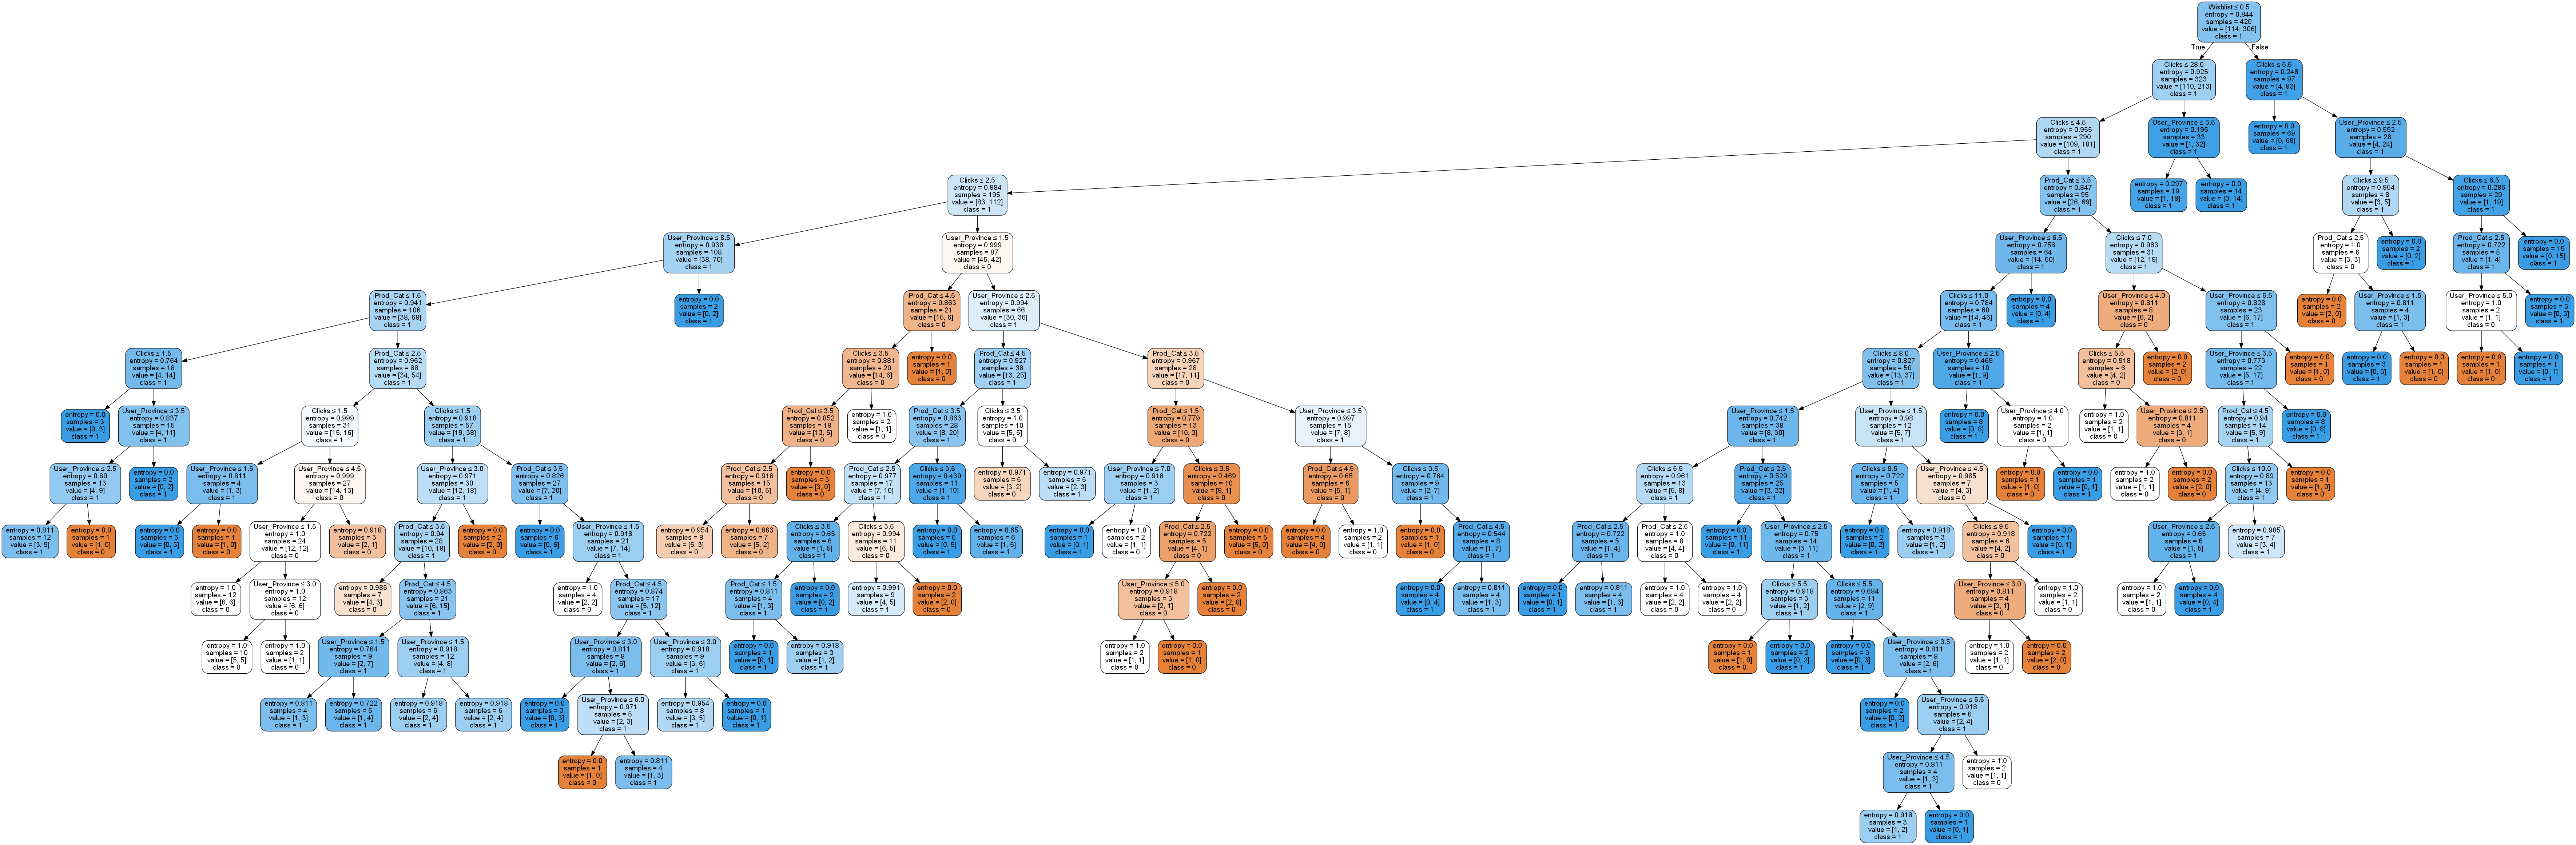

In [7]:
#Performance testing using our validation data..... X_test was initialised as a validation set...

#Before Pruning!!!!!!!!!!!!!!!!!!!!!!!!
y_predict = clf.predict(X_test)

#Get the accuracy of the model clf...

AccuracyBeforePruning = metrics.accuracy_score(y_test, y_predict)
print("-----------------------------------------------ACCURACY BEFORE PRUNING---------------------------------\n")
print(colored(AccuracyBeforePruning, 'green'))
print("\n-------------------------------------------------------------------------------------------------------\n")


#Building the decision tree, the visual decision tree diagram and exporting the diagram as .png and 
# saved under the assests folder in our project... 
r = export_text(clf, feature_names=feature_cols)

print(colored(r, 'blue'))

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../../assets/decision_tree/decision_tree_outputs/recommendations.png')
Image(graph.create_png())

-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------

0.6142857142857143

-------------------------------------------------------------------------------------------------------

|--- Wishlist <= 0.50
|   |--- Clicks <= 28.00
|   |   |--- Clicks <= 4.50
|   |   |   |--- Clicks <= 2.50
|   |   |   |   |--- class: 1
|   |   |   |--- Clicks >  2.50
|   |   |   |   |--- class: 0
|   |   |--- Clicks >  4.50
|   |   |   |--- Prod_Cat <= 3.50
|   |   |   |   |--- class: 1
|   |   |   |--- Prod_Cat >  3.50
|   |   |   |   |--- class: 1
|   |--- Clicks >  28.00
|   |   |--- User_Province <= 3.50
|   |   |   |--- class: 1
|   |   |--- User_Province >  3.50
|   |   |   |--- class: 1
|--- Wishlist >  0.50
|   |--- Clicks <= 5.50
|   |   |--- class: 1
|   |--- Clicks >  5.50
|   |   |--- User_Province <= 2.50
|   |   |   |--- Clicks <= 9.50
|   |   |   |   |--- class: 0
|   |   |   |--- Clicks >  9.50
|   |   |   |   |--- class: 1
|   |   |--- User_Pr

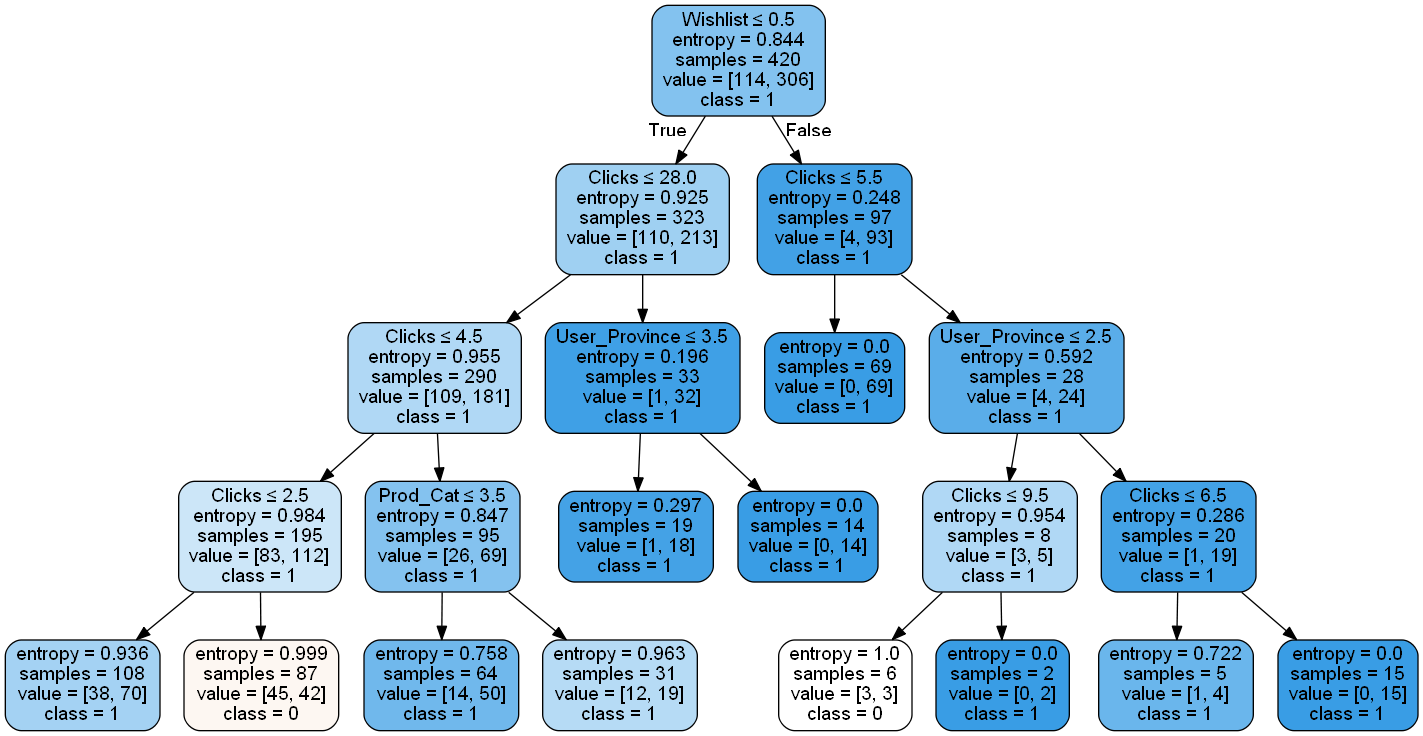

In [8]:
#After Pruning!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#We prune the tree to reduce the complexity, makes it easier to interpret 
# by cutting off the redundency of some nodes of the tree... 
# 
#Sometimes there's a tradeoff between removing redundency and a slight decrease in model accuracy... A fair tradeoff....
# what's good about our model is that most of the time the accuracy before and after pruning is likely the same, or even better after pruning

clf = DecisionTreeClassifier(criterion="entropy", max_depth=4) #Given a depth of 4 to make the tree less complicated(Avoid overfitting)

clf = clf.fit(X_train,y_train) #Train it again...

y_pred = clf.predict(X_test)

AccuracyAfterPruning = metrics.accuracy_score(y_test, y_pred)

r = export_text(clf, feature_names=feature_cols)

if(AccuracyBeforePruning <= AccuracyAfterPruning):
    print("-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------\n")
    print(colored(AccuracyAfterPruning, 'lime'))
    print("\n-------------------------------------------------------------------------------------------------------\n")

    print(colored(r, 'green'))
else:
    print("-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------\n")
    print(colored(AccuracyAfterPruning, 'red'))
    print("\n-------------------------------------------------------------------------------------------------------\n")

    print(colored(r, 'red'))

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../../assets/decision_tree/decision_tree_outputs/recommendations(Pruned).png')
Image(graph.create_png())


In [9]:
#Exporting and saving our accuracy file in a form Accuracy Before Pruning, Accuracy After Pruning
accuracy = []
accuracy.append(AccuracyBeforePruning)
accuracy.append(AccuracyAfterPruning)
np.savetxt("../../assets/decision_tree/decision_tree_outputs/accuracies.csv", accuracy, delimiter=",", fmt='%s')

#Exporting our final files to firebase (Note these are global files, files that do not depend on the user -- hence we didn't push the final _recommendations.csv file)
#First we append them into an array...
ai_results = []

ai_results.append('decision_tree/decision_tree_outputs/recommendations.png')
ai_results.append('decision_tree/decision_tree_outputs/recommendations(Pruned).png')
ai_results.append('decision_tree/decision_tree_outputs/accuracies.csv')

for x in ai_results:

    bucket = storage.bucket()
    blob = bucket.blob(x)
    outfile='../../assets/' + x
    with open(outfile, 'rb') as my_file:
        blob.upload_from_file(my_file)

